In [68]:
import numpy as np
import matplotlib.pyplot as plt
import rasterio
import os
from utils.functions import get_files_info
from scipy.stats import norm

In [54]:
def calculate_ndvi(red_band, nir_band):
    denominator = nir_band + red_band
    ndvi = np.where(
        denominator != 0,
        (nir_band - red_band) / denominator,
        0.0
    )
    return ndvi

def vectorize_sentinel_ndvi_256(file_path, red_idx=3, nir_idx=7):
    with rasterio.open(file_path) as src:
        img = src.read() 

        red = img[red_idx].astype(np.float32)
        nir = img[nir_idx].astype(np.float32)

        ndvi = calculate_ndvi(red, nir)    
        X = ndvi.reshape(-1)                

    return X

In [55]:
base_dir = "s2_ejura_2018_2019"
n_files, name_files = get_files_info(base_dir)

name_files = sorted(name_files)
full_paths = [os.path.join(base_dir, fname) for fname in name_files]

ndvi_time_series = []

for file_path in full_paths:
    ndvi_vector = vectorize_sentinel_ndvi_256(file_path)
    ndvi_time_series.append(ndvi_vector)

ndvi_time_series = np.array(ndvi_time_series)

X = ndvi_time_series.T 
X.shape

Total number of files: 26


(65536, 26)

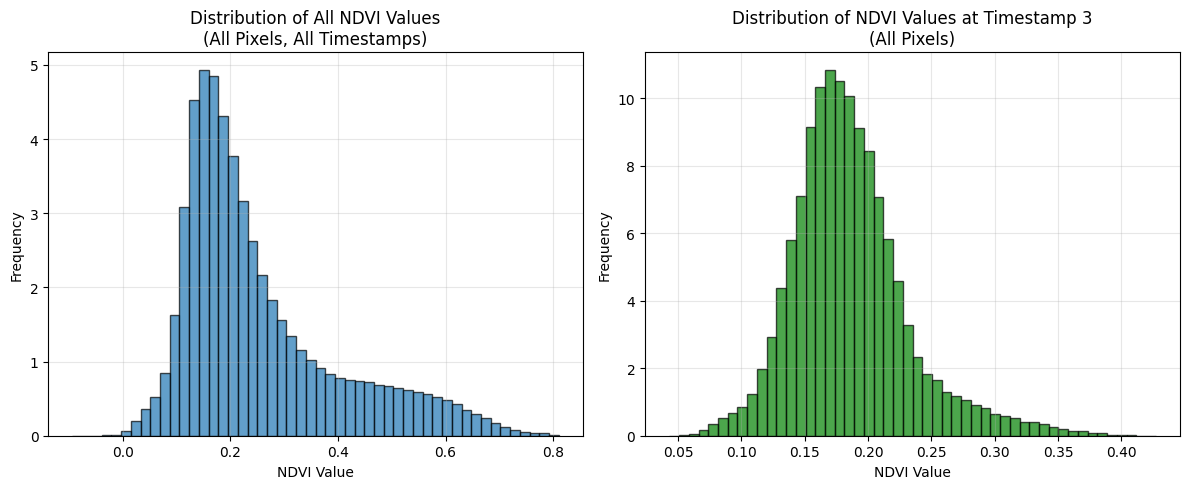

In [75]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.hist(X.flatten(), bins=50, edgecolor='black', alpha=0.7, density=True)
plt.xlabel('NDVI Value')
plt.ylabel('Frequency')
plt.title('Distribution of All NDVI Values\n(All Pixels, All Timestamps)')
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
timestamp_idx = 3
ndvi_at_timestamp = X[:, timestamp_idx]
p_x = plt.hist(ndvi_at_timestamp, bins=50, edgecolor='black', alpha=0.7, color='green', density=True)
plt.xlabel('NDVI Value')
plt.ylabel('Frequency')
plt.title(f'Distribution of NDVI Values at Timestamp {timestamp_idx}\n(All Pixels)')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [77]:
timestamp_idx = 23
ndvi_at_timestamp = X[:, timestamp_idx]

mu_t = np.mean(ndvi_at_timestamp)
sigma_t = np.std(ndvi_at_timestamp)

p_xt = norm.pdf(ndvi_at_timestamp, mu_t, sigma_t)

anomaly_mask = p_xt < 1e-3
anomaly_indices = np.where(anomaly_mask)[0]

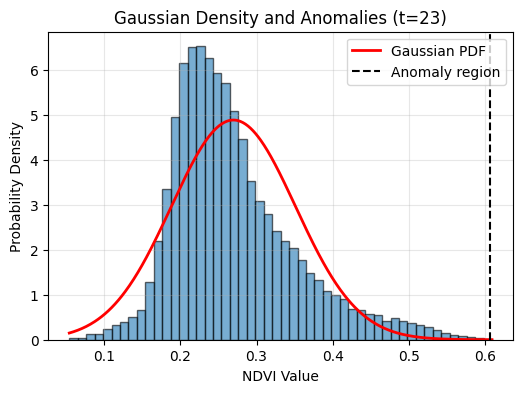

In [78]:
x_vals = np.linspace(ndvi_at_timestamp.min(), ndvi_at_timestamp.max(), 500)
pdf_vals = norm.pdf(x_vals, mu_t, sigma_t)

plt.figure(figsize=(6, 4))
plt.hist(ndvi_at_timestamp, bins=50, density=True, alpha=0.6, edgecolor='black')
plt.plot(x_vals, pdf_vals, 'r', linewidth=2, label='Gaussian PDF')

plt.axvline(
    ndvi_at_timestamp[anomaly_mask].min(),
    color='black', linestyle='--', label='Anomaly region'
)

plt.xlabel('NDVI Value')
plt.ylabel('Probability Density')
plt.title(f'Gaussian Density and Anomalies (t={timestamp_idx})')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()
